In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.models import load_model
import matplotlib.pyplot as plt
import pickle

In [9]:
data = pd.read_csv('dataset/data_gabungan.csv')
data.head()

,Nama,Jenis Kelamin
0,ABDUL MALIK,LAKI-LAKI
1,ADELIA,PEREMPUAN
2,AMAN AMINUS,LAKI-LAKI
3,ANGGARA SYAPUTRA,LAKI-LAKI
4,ANISA SASABILA,PEREMPUAN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19186 entries, 0 to 19185
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Nama           19186 non-null  object
 1   Jenis Kelamin  19186 non-null  object
dtypes: object(2)
memory usage: 299.9+ KB


In [5]:
data.isnull().sum()

Nama             0
Jenis Kelamin    0
dtype: int64

In [6]:
data['Jenis Kelamin'].value_counts()

PEREMPUAN    11335
LAKI-LAKI     7851
Name: Jenis Kelamin, dtype: int64

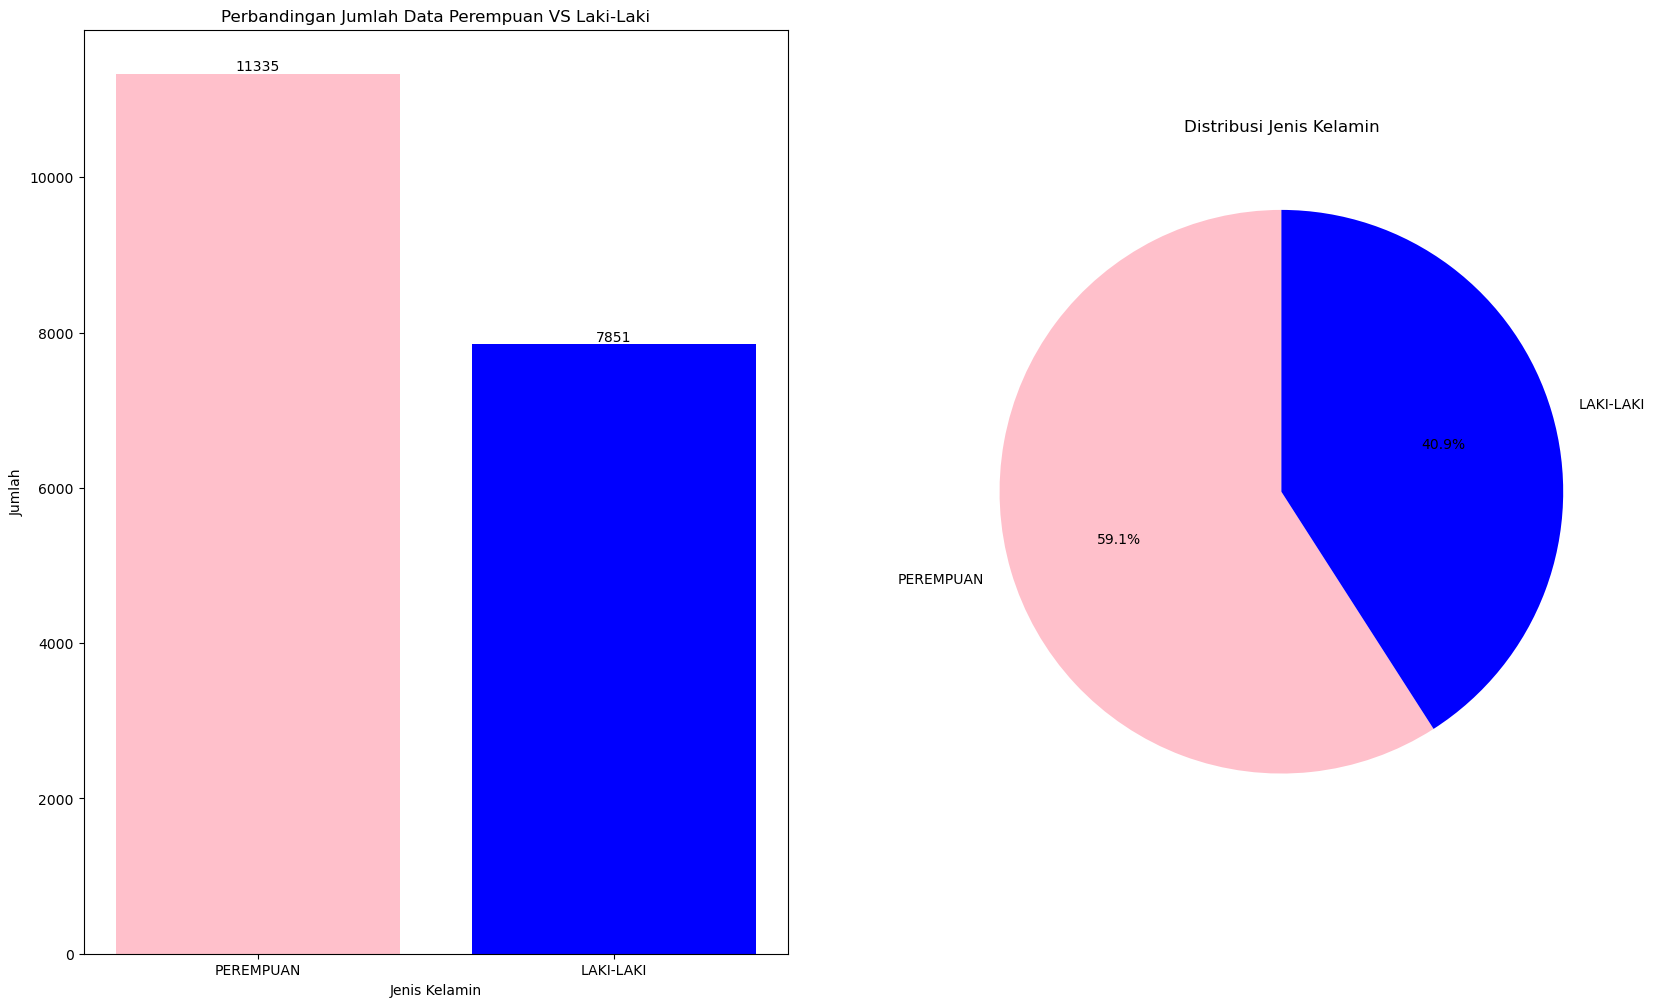

In [10]:
gender_counts = data['Jenis Kelamin'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

# Bar chart
bars = ax1.bar(gender_counts.index, gender_counts, color=['pink', 'blue'])
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval), ha='center', va='bottom')

ax1.set_title('Perbandingan Jumlah Data Perempuan VS Laki-Laki')
ax1.set_xlabel('Jenis Kelamin')
ax1.set_ylabel('Jumlah')
ax1.set_xticks(gender_counts.index)
ax1.set_xticklabels(gender_counts.index, rotation=0)

# Pie chart
ax2.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['pink', 'blue'], startangle=90)
ax2.set_title('Distribusi Jenis Kelamin')

plt.show()

In [11]:
def preprocess_data(data):
    data['Jenis Kelamin'] = data['Jenis Kelamin'].replace({'PEREMPUAN': 0, 'LAKI-LAKI': 1})

    nama = [nama.lower().split() for nama in data['Nama']]
    word2vec_model = Word2Vec(nama, vector_size=100, window=7, min_count=1, workers=8)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(nama)

    return data, word2vec_model, tokenizer

In [12]:
def tokenize_sequences(data, tokenizer):
    X = data['Nama']
    y = data['Jenis Kelamin']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    max_len = max(len(seq) for seq in X_train_sequences)

    X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
    X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

    return X_train_padded, X_test_padded, y_train, y_test, max_len

In [13]:
data_preprocess, word2vec_mode, tokenizer = preprocess_data(data)

In [14]:
X_train_padded, X_test_padded, y_train, y_test, max_len = tokenize_sequences(data, tokenizer)

In [15]:
with open('model/tokenizer.pickle', 'wb') as handle:
    pickle.dump((tokenizer, max_len), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
def model_lstm(input_dim, output_dim, max_len):
   model = Sequential()
   model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_len))
   model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
   model.add(Dropout(0.5))

   # Layer Bidirectional LSTM 2
   model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
   model.add(Dropout(0.5))

   # Layer Bidirectional LSTM 3
   model.add(Bidirectional(LSTM(units=100)))
   model.add(Dropout(0.5))
   model.add(Dense(1, activation='sigmoid'))
   
   return model

In [17]:
input_dim = len(tokenizer.word_index) + 1
output_dim = 100
max_len = max(len(seq) for seq in X_train_padded)

In [18]:
model = model_lstm(input_dim, output_dim, max_len)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 100)            1565100   
                                                                 
 bidirectional (Bidirectiona  (None, 6, 200)           160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 6, 200)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 200)           240800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 200)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              2

In [19]:
model.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [20]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-3,
        patience=5,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
]

In [21]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=100,
    validation_data=[X_test_padded, y_test],
    callbacks=[callbacks]
)

Epoch 1/100
480/480 [==============================] - 152s 268ms/step - loss: 0.5070 - accuracy: 0.7374 - val_loss: 0.4202 - val_accuracy: 0.7926
Epoch 2/100
480/480 [==============================] - 105s 219ms/step - loss: 0.2161 - accuracy: 0.9132 - val_loss: 0.4386 - val_accuracy: 0.7876
Epoch 3/100
480/480 [==============================] - 105s 219ms/step - loss: 0.1342 - accuracy: 0.9351 - val_loss: 0.4858 - val_accuracy: 0.7699
Epoch 4/100
480/480 [==============================] - 103s 215ms/step - loss: 0.1157 - accuracy: 0.9367 - val_loss: 0.5408 - val_accuracy: 0.7671
Epoch 5/100
480/480 [==============================] - 105s 218ms/step - loss: 0.1061 - accuracy: 0.9380 - val_loss: 0.5099 - val_accuracy: 0.7916
Epoch 6/100
480/480 [==============================] - 259s 539ms/step - loss: 0.1014 - accuracy: 0.9417 - val_loss: 0.5840 - val_accuracy: 0.7699
Epoch 6: early stopping


In [22]:
accuracy = model.evaluate(X_train_padded, y_train)[1]
print('Training Accuracy: ', accuracy * 100, '%')

480/480 [==============================] - 4s 8ms/step - loss: 0.2364 - accuracy: 0.9184
Training Accuracy:  91.84258580207825 %


In [23]:
val_accuracy = model.evaluate(X_test_padded, y_test)[1]
print('Validation Accuracy: ', val_accuracy * 100, '%')

120/120 [==============================] - 1s 8ms/step - loss: 0.4202 - accuracy: 0.7926
Validation Accuracy:  79.26003336906433 %


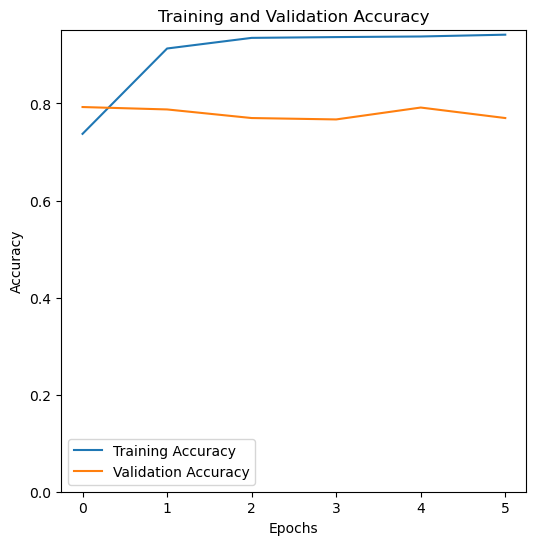

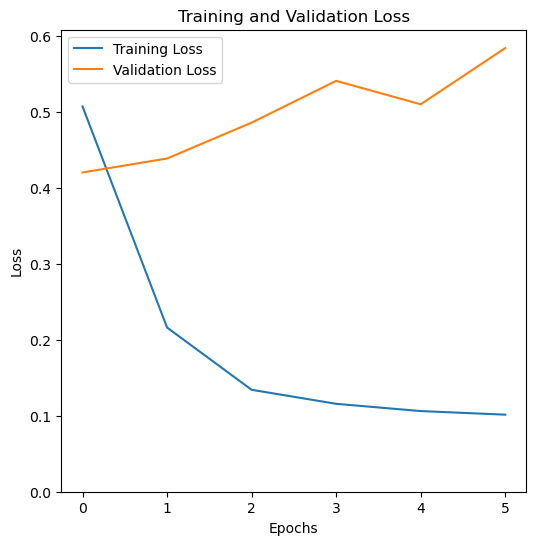

In [24]:
def plot_accuracy(history):
    plt.figure(figsize=(6, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(bottom=0)
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig('image/accuracy.png')
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(6, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(bottom=0)
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('image/loss.png')
    plt.show()

def show_plot(history):
    plot_accuracy(history)
    plot_loss(history)

show_plot(history)

In [25]:
model.save('model/model_modifikasi.h5')

In [26]:
def predict_gender(name, tokenizer, max_len, model):
    name_sequence = tokenizer.texts_to_sequences([name.lower()])
    padded_sequence = pad_sequences(name_sequence, maxlen=max_len, padding='post')
    prediction = model.predict(padded_sequence)
    gender_label = 'Laki-Laki' if prediction[0] >= 0.5 else 'Perempuan'
    confidence_score = prediction if gender_label == 'Laki-Laki' else 1 - prediction
    return gender_label, confidence_score

In [27]:
nama = 'Dewa Sheva Dzaky'
pred_model = load_model('model/model_modifikasi.h5')
predicted_gender, predicted_score = predict_gender(nama, tokenizer, max_len, pred_model)
print(f'Predicted gender for {nama}: {predicted_gender} with confidence score: {predicted_score}')

1/1 [==============================] - 14s 14s/step
Predicted gender for Dewa Sheva Dzaky: Laki-Laki with confidence score: [[0.8274292]]
